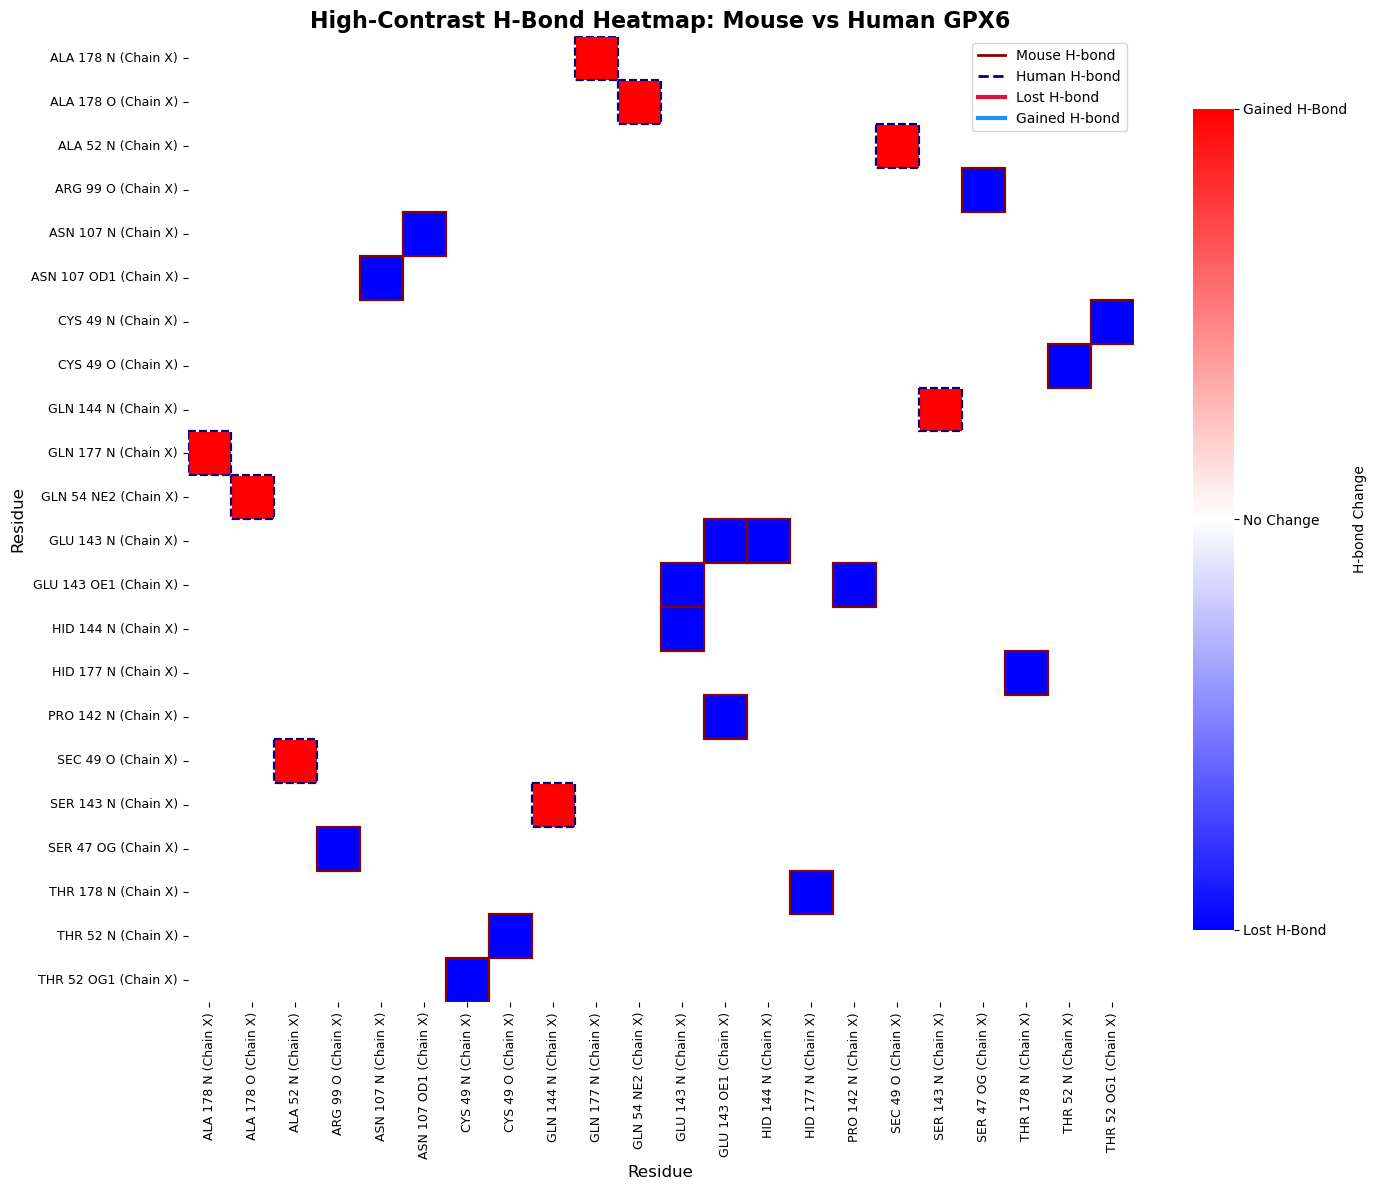

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

def parse_hbonds(file_path):
    with open(file_path) as f:
        lines = f.readlines()
    hbond_lines = [line.strip() for line in lines if line.startswith("H-Bond:")]
    
    hbond_set = set()
    hbond_details = []
    for line in hbond_lines:
        match = re.match(r"H-Bond: (.+) → (.+) \(Distance: ([\d.]+) Å\)", line)
        if match:
            donor, acceptor, dist = match.groups()
            hbond = tuple(sorted([donor.strip(), acceptor.strip()]))
            hbond_set.add(hbond)
            hbond_details.append((donor.strip(), acceptor.strip(), float(dist)))
    return hbond_set, hbond_details

# File paths
mouse_file = "/home/hp/nayanika/github/GPX6/results/mousecys_hbond_info.txt"
human_file = "/home/hp/nayanika/github/GPX6/results/humansec_hbond_info.txt"

mouse_hbonds, mouse_details = parse_hbonds(mouse_file)
human_hbonds, human_details = parse_hbonds(human_file)

lost = mouse_hbonds - human_hbonds
gained = human_hbonds - mouse_hbonds
shared = mouse_hbonds & human_hbonds

gained_details = [(d, a) for d, a, _ in human_details if tuple(sorted([d, a])) in gained]
lost_details = [(d, a) for d, a, _ in mouse_details if tuple(sorted([d, a])) in lost]
mouse_pairs = [tuple(sorted([d, a])) for d, a, _ in mouse_details]
human_pairs = [tuple(sorted([d, a])) for d, a, _ in human_details]

all_residues = set()
for d, a in gained_details + lost_details + mouse_pairs + human_pairs:
    all_residues.update([d, a])

sorted_residues = sorted(all_residues)
residue_index = {res: i for i, res in enumerate(sorted_residues)}
n = len(sorted_residues)

matrix = np.zeros((n, n))

for d, a in gained_details:
    i, j = residue_index[d], residue_index[a]
    matrix[i, j] = matrix[j, i] = 1

for d, a in lost_details:
    i, j = residue_index[d], residue_index[a]
    matrix[i, j] = matrix[j, i] = -1

# Strong contrast plotting
plt.figure(figsize=(14, 12))
ax = sns.heatmap(matrix, cmap="bwr", center=0,
                 xticklabels=sorted_residues,
                 yticklabels=sorted_residues,
                 linewidths=0.5, linecolor='white',
                 cbar_kws={'label': 'H-bond Change', 'shrink': 0.85})

# Bold overlays
for (d, a) in mouse_pairs:
    i, j = residue_index[d], residue_index[a]
    ax.add_patch(Rectangle((j, i), 1, 1, fill=False, edgecolor='darkred', lw=1.5))
    ax.add_patch(Rectangle((i, j), 1, 1, fill=False, edgecolor='darkred', lw=1.5))

for (d, a) in human_pairs:
    i, j = residue_index[d], residue_index[a]
    ax.add_patch(Rectangle((j, i), 1, 1, fill=False, edgecolor='navy', lw=1.5, linestyle='--'))
    ax.add_patch(Rectangle((i, j), 1, 1, fill=False, edgecolor='navy', lw=1.5, linestyle='--'))

# Labels and text
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=9)
plt.title("High-Contrast H-Bond Heatmap: Mouse vs Human GPX6", fontsize=16, fontweight='bold')
plt.xlabel("Residue", fontsize=12)
plt.ylabel("Residue", fontsize=12)

# Colorbar settings
cbar = ax.collections[0].colorbar
cbar.set_ticks([-1, 0, 1])
cbar.set_ticklabels(['Lost H-Bond', 'No Change', 'Gained H-Bond'])
cbar.ax.tick_params(labelsize=10)

# Clear, contrasting legend
legend_elements = [
    Line2D([0], [0], color='darkred', lw=2, label='Mouse H-bond'),
    Line2D([0], [0], color='navy', lw=2, linestyle='--', label='Human H-bond'),
    Line2D([0], [0], color='crimson', lw=3, label='Lost H-bond'),
    Line2D([0], [0], color='dodgerblue', lw=3, label='Gained H-bond'),
]
plt.legend(handles=legend_elements, loc='upper right', fontsize=10, frameon=True)

plt.tight_layout()
plt.savefig("high_contrast_hbond_heatmap.png", dpi=300)
plt.show()
